# Simplex Method

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Problem, maximize $cx$ subject to $Ax \le b$. We will suppose $b > 0$.

In [53]:
c = np.array([1, 1]).reshape(1, -1)
A = np.array([
    [2, 1],
    [1, 2]
])
b = np.array([1, 1]).reshape(-1, 1)

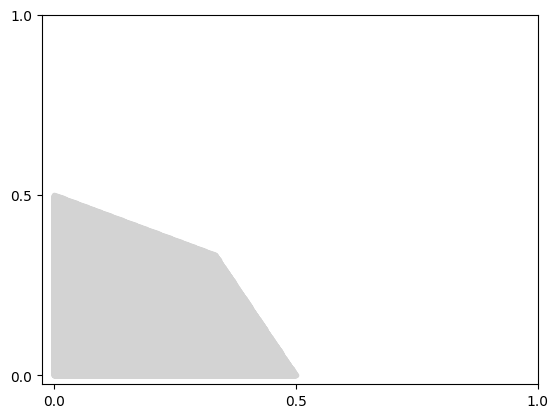

In [91]:
mesh = np.linspace(0, 1, 1000)
x_mesh, y_mesh = np.meshgrid(mesh, mesh)
grid = np.stack([
    x_mesh.reshape([*x_mesh.shape, 1]),
    y_mesh.reshape([*y_mesh.shape, 1])
], axis=2)

feasible = np.all((A @ grid) < b.reshape([1, 1, *b.shape]), axis=-2).reshape([*x_mesh.shape])

plt.plot(*np.where(feasible), ".", color="lightgray")
tick_indexes = [0, len(mesh)//2, len(mesh)-1]
plt.xticks(np.arange(len(mesh))[tick_indexes], np.round(mesh[tick_indexes], 2))
plt.yticks(np.arange(len(mesh))[tick_indexes], np.round(mesh[tick_indexes], 2))
plt.show()

## The Tableau

Introduce the slack variables to make the constraint into $Ax + IS = b$, where $S \ge 0$.

We're going to map this whole system of equations into a block matrix called the tableau.

$$
\begin{bmatrix}
    A & S & b \\
    -c & 0 & 0\\
\end{bmatrix}
$$

The top row of the block matrix represents the constraints, and the bottom row represents the objective function. We initialize this bottom row at $-cx = z = 0$.

In [111]:
S = np.eye(b.size) # slack variables

T = np.block([
    [A, S, b],
    [-c, np.zeros([1, b.size + 1])]
])

T

array([[ 2.,  1.,  1.,  0.,  1.],
       [ 1.,  2.,  0.,  1.,  1.],
       [-1., -1.,  0.,  0.,  0.]])

## Basic Variables

A key concept in the simplex algorithm is the idea of basic variables. In the tableau, a column corresponds to a basic variable if every entry is a zero except for one, which is a one. In the initial tableau, the slack variable are the basic variables.

If we think about what this means in the math, it's saying that we have put the equations in a form where there is exactly only one constraint on the variable, and in that constraint the coefficient on the basic variable is one. For example, in the intitial tableau above, $s_1$ is a basic variable, and row 1 corresponds to $2 x_1 + x_2 + s_1 = 1$.

What this means is that there is a specific solution to the equations where we set each basic variable to the value of the last column at the row where the basic variable is nonzero.



We can perform row operations on 

We have two interpretations for this system. The first interpretation is that, this represents the system of linear equations defining our system. We can perform row operations and this system will remain unchanged.

In [129]:
def specific_solution(T):
    n_slack_vars = T.shape[0] - 1
    n_vars = T.shape[1] - n_slack_vars - 1

    basic_vars = []
    for j, col in enumerate(T.T):
        if np.sum(col) == 1 and np.sum(col[col != 0]) == 1:
            i = np.where(col)[0][0]
            basic_vars.append((i, j))

    for i, j in basic_vars:
        slack = (j + 1) > n_vars
        char = "s" if slack else "x"
        index = j if not slack else j - n_vars
        value = T[i, -1]
        print(f"{char}{index} = {value}")

print(T)
print()
specific_solution(T)

[[ 2.  1.  1.  0.  1.]
 [ 1.  2.  0.  1.  1.]
 [-1. -1.  0.  0.  0.]]

s0 = 1.0
s1 = 1.0


## Pivots

Since the tableau represents a linear system, we can apply row operations without modifying the solution set. Transformations like this will change which variables are basic in the tableau though, and so they will change the specific solution that the tableau is associated with.

Below is a function that will use row operations to make a variable into a basic variable

In [130]:
# perform row operations to create a new basic variable
def ge(A, pos):
    A = A.copy()
    row, col = pos

    # make pivot equal one
    if A[row, col] == 0:
        for i in range(0, A.shape[0]):
            if A[i, col] != 0:
                A[row, :] += A[i, :]
                break
    if A[row, col] == 0:
        raise ValueError("Pivot column is zero")
    A[row, :] = A[row, :] / A[row, col]

    # make other rows in the pivot column zero
    for i in range(A.shape[0]):
        if i != row:
            factor = A[i, col] / A[row, col]
            A[i, :] = A[i, :] - factor * A[row, :]
    return A

In [131]:
print(T)
specific_solution(T)
print()
print(ge(T, (1, 0)))
specific_solution(ge(T, (1, 0)))

[[ 2.  1.  1.  0.  1.]
 [ 1.  2.  0.  1.  1.]
 [-1. -1.  0.  0.  0.]]
s0 = 1.0
s1 = 1.0

[[ 0. -3.  1. -2. -1.]
 [ 1.  2.  0.  1.  1.]
 [ 0.  1.  0.  1.  1.]]
x0 = 1.0
s0 = -1.0
s2 = -1.0


How do we decide which operations to perform next? For maximization, we are going to make a basic variable out of the variable with the largest negative coefficient in the bottom row. The coefficients along the bottom row represent the $dz/dx_i$, so we want to change the one that has the steepest slope.



In [108]:
def pick_pivot(T, n_vars=A.shape[1]):
    obj_coefs = T[-1, 0:n_vars]
    col = np.argmin(obj_coefs)
    ratio = T[:-1, -1]/T[:-1, col]
    row = np.argmin(ratio)
    return [row, col]

def step(T):
    return ge(T, pick_pivot(T))

def done(T, n_vars=A.shape[1]):
    z_coefs = T[-1, :n_vars]
    return np.all(z_coefs >= 0)

limit = 10
i = 0
while not done(T):
    i += 1
    T = step(T)

    if i > limit:
        print("limit exceeded")
        break

np.round(T)

[[-1.  2.  1.  3.  4.  1.  0.  0.  3.]
 [ 4.  1. -2.  3.  1.  0.  1.  0.  2.]
 [-4. -2.  2.  1.  3.  0.  0.  1.  6.]
 [-1. -2. -3. -4. -5.  0.  0.  0.  0.]]


array([[ 3.60287970e+15,  1.30604389e+16,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  3.60287970e+15,
        -2.25179981e+15, -4.05323966e+15, -1.80143985e+16],
       [ 3.60287970e+15,  1.30604389e+16,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  3.60287970e+15,
        -2.25179981e+15, -4.05323966e+15, -1.80143985e+16],
       [-3.60287970e+15, -1.30604389e+16,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00, -3.60287970e+15,
         2.25179981e+15,  4.05323966e+15,  1.80143985e+16],
       [ 7.20575940e+15,  2.61208778e+16,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  7.20575940e+15,
        -4.50359963e+15, -8.10647933e+15, -3.60287970e+16]])

## More on the basic feasible solution

You might be in a situation where you have equality constraints. In this case, finding the initial solution can itself be a linear programming problem. To solve this, with the constraint that, e.g., some of your variables need to be positive, you can use simplex to minimize the distance between your solution and the equality constraints.